In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Importing


In [ ]:
# Function to load vibration data from a directory
def load_vibration_data(directory):
    data = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        file_data = pd.read_csv(file_path, skiprows=5, header=None).to_numpy().flatten()
        data.append(file_data)
    return np.array(data)

# Load healthy and unbalanced training data
train_healthy_path = '/content/drive/MyDrive/ENME691/HW3/Training/Healthy'
train_unbalanced_path1 = '/content/drive/MyDrive/ENME691/HW3/Training/Faulty/Unbalance 1'
train_unbalanced_path2 = '/content/drive/MyDrive/ENME691/HW3/Training/Faulty/Unbalance 2'
test_path = '/content/drive/MyDrive/ENME691/HW3/Testing'

healthy_data = load_vibration_data(train_healthy_path)
unbalanced_data1 = load_vibration_data(train_unbalanced_path1)
unbalanced_data2 = load_vibration_data(train_unbalanced_path2)
test_data = load_vibration_data(test_path)


FFT

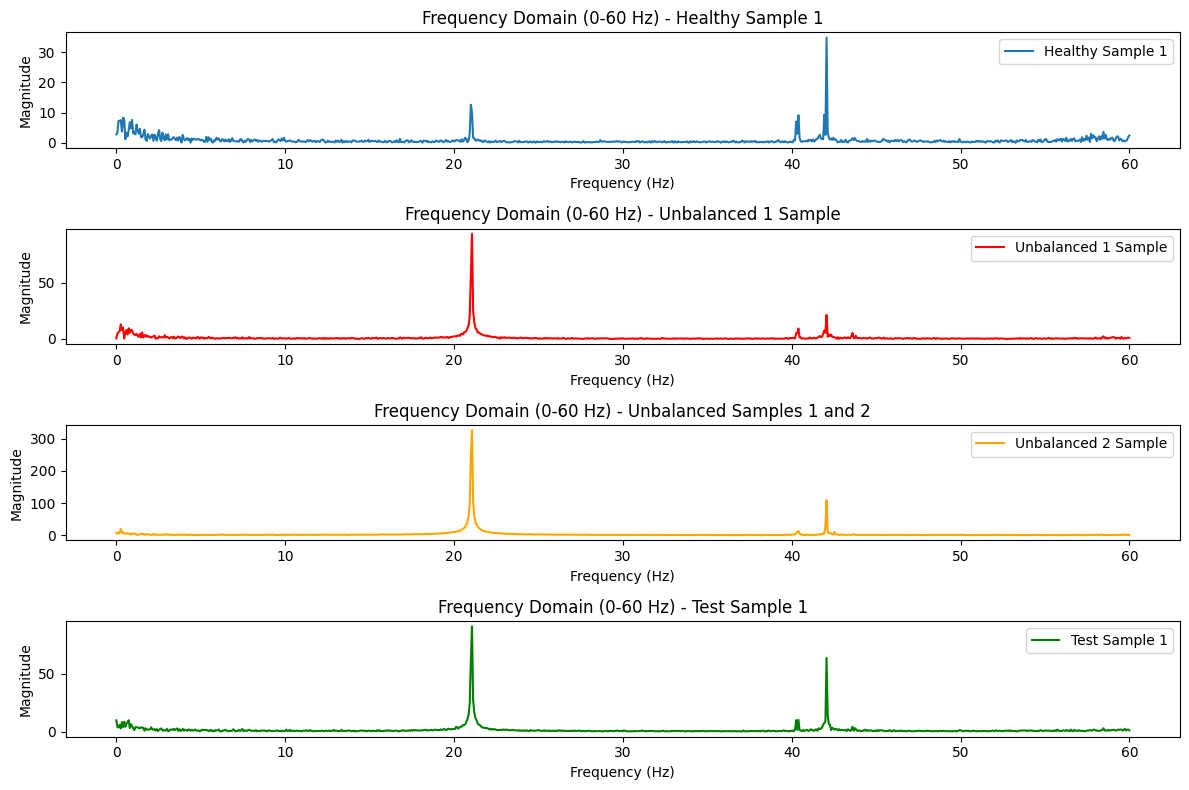

In [ ]:
# Function to perform FFT on a single sample
def perform_fft(data, sampling_rate=2560):
    n = len(data)
    fft_values = fft(data)
    frequency = fftfreq(n, d=1/sampling_rate)
    return frequency, fft_values, n

# Calculate FFT for the first sample of each class in the training data
healthy_freq, healthy_fft, n_healthy = perform_fft(healthy_data[0])
unbalanced_freq1, unbalanced_fft1, n_unbalanced1 = perform_fft(unbalanced_data1[0])
unbalanced_freq2, unbalanced_fft2, n_unbalanced2 = perform_fft(unbalanced_data2[0])

# Perform FFT for the first test sample
test_freq, test_fft, n_test = perform_fft(test_data[0])

# Limit the FFT to the 0 to 60 Hz frequency range for all data
healthy_fft_60Hz = healthy_fft[np.abs(healthy_freq) <= 60]
unbalanced1_fft_60Hz = unbalanced_fft1[np.abs(unbalanced_freq1) <= 60]
unbalanced2_fft_60Hz = unbalanced_fft2[np.abs(unbalanced_freq2) <= 60]
test_fft_60Hz = test_fft[np.abs(test_freq) <= 60]

healthy_freq_60Hz = healthy_freq[np.abs(healthy_freq) <= 60]
unbalanced1_freq_60Hz = unbalanced_freq1[np.abs(unbalanced_freq1) <= 60]
unbalanced2_freq_60Hz = unbalanced_freq2[np.abs(unbalanced_freq2) <= 60]
test_freq_60Hz = test_freq[np.abs(test_freq) <= 60]

# Filter for positive frequencies (0 to 60 Hz) for each set
positive_idx_healthy = (healthy_freq_60Hz >= 0) & (healthy_freq_60Hz <= 60)
positive_idx_unbalanced1 = (unbalanced1_freq_60Hz >= 0) & (unbalanced1_freq_60Hz <= 60)
positive_idx_unbalanced2 = (unbalanced2_freq_60Hz >= 0) & (unbalanced2_freq_60Hz <= 60)
positive_idx_test = (test_freq_60Hz >= 0) & (test_freq_60Hz <= 60)

# Plot the magnitude of the FFT (frequency domain) for 0 to 60 Hz
plt.figure(figsize=(12, 8))

# Healthy Sample 1
plt.subplot(4, 1, 1)
plt.plot(healthy_freq_60Hz[positive_idx_healthy], np.abs(healthy_fft_60Hz[positive_idx_healthy]), label='Healthy Sample 1')
plt.title('Frequency Domain (0-60 Hz) - Healthy Sample 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

# Unbalanced Sample 1
plt.subplot(4, 1, 2)
plt.plot(unbalanced1_freq_60Hz[positive_idx_unbalanced1], np.abs(unbalanced1_fft_60Hz[positive_idx_unbalanced1]), label='Unbalanced 1 Sample', color='red')
plt.title('Frequency Domain (0-60 Hz) - Unbalanced 1 Sample')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

# Unbalanced Sample 2
plt.subplot(4, 1, 3)
plt.plot(unbalanced2_freq_60Hz[positive_idx_unbalanced2], np.abs(unbalanced2_fft_60Hz[positive_idx_unbalanced2]), label='Unbalanced 2 Sample', color='orange')
plt.title('Frequency Domain (0-60 Hz) - Unbalanced Samples 1 and 2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

# Test Sample 1
plt.subplot(4, 1, 4)
plt.plot(test_freq_60Hz[positive_idx_test], np.abs(test_fft_60Hz[positive_idx_test]), label='Test Sample 1', color='green')
plt.title('Frequency Domain (0-60 Hz) - Test Sample 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Amplitude')

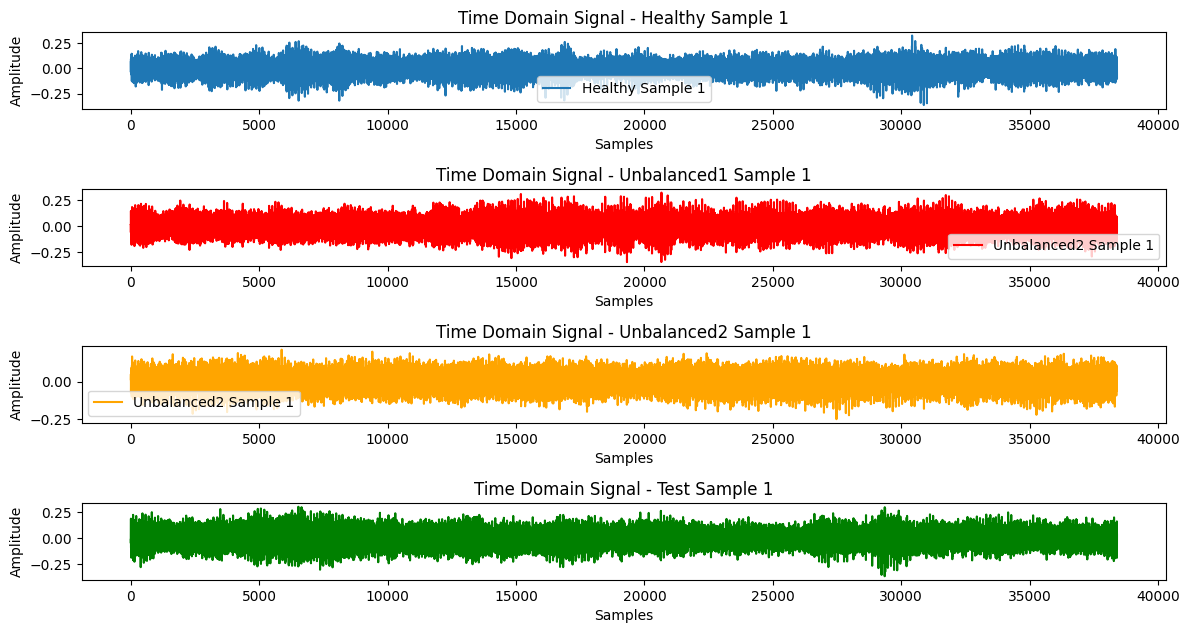

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(healthy_data[0], label='Healthy Sample 1')
plt.title('Time Domain Signal - Healthy Sample 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(unbalanced_data1[0], label='Unbalanced2 Sample 1', color='red')
plt.title('Time Domain Signal - Unbalanced1 Sample 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

plt.subplot(4, 1, 3)
plt.plot(unbalanced_data2[0], label='Unbalanced2 Sample 1', color='orange')
plt.title('Time Domain Signal - Unbalanced2 Sample 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

plt.subplot(4, 1, 4)
plt.plot(test_data[0], label='Test Sample 1', color='green')
plt.title('Time Domain Signal - Test Sample 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')


Feature Extraction

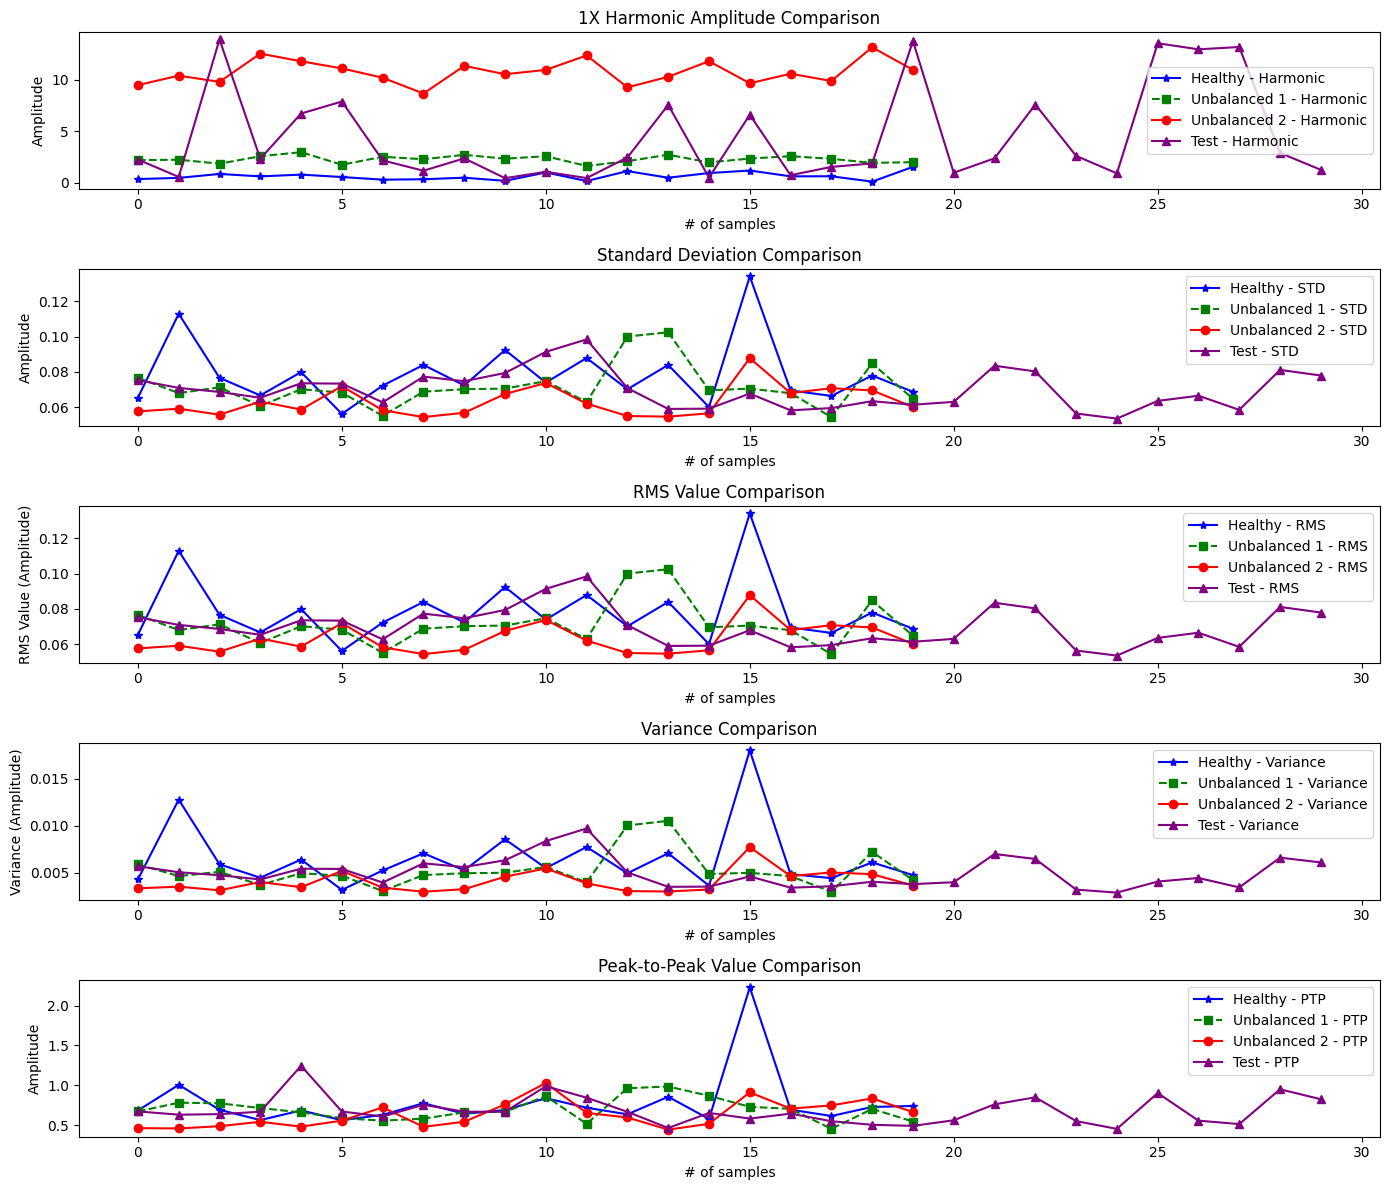

In [ ]:
# Function to compute FFT and extract 1X harmonic amplitude
def get_1x_harmonic_amplitude(data, sampling_rate=2560):
    n = len(data)
    frequency = fftfreq(n, d=1/sampling_rate)
    fft_values = fft(data)
    harmonic_1x_amplitude = np.abs(fft_values[np.argmin(np.abs(frequency - 20))])  # Find 1X harmonic near 20 Hz
    return harmonic_1x_amplitude

# Function to compute standard deviation in the time domain
def get_std_in_time_domain(data):
    return np.std(data)

# Function to compute RMS value
def get_rms_value(data):
    return np.sqrt(np.mean(data**2))

# Function to compute variance
def get_variance(data):
    return np.var(data)

# Function to compute peak-to-peak value
def get_peak_to_peak_value(data):
    return np.ptp(data)

# Generate all features (1X harmonic, STD, RMS, variance, peak-to-peak) for each sample in the dataset
def compute_features(data_samples):
    harmonic_amplitudes = []
    std_devs = []
    rms_values = []
    variances = []
    peak_to_peaks = []

    for data in data_samples:
        harmonic_amplitudes.append(get_1x_harmonic_amplitude(data))
        std_devs.append(get_std_in_time_domain(data))
        rms_values.append(get_rms_value(data))
        variances.append(get_variance(data))
        peak_to_peaks.append(get_peak_to_peak_value(data))

    return harmonic_amplitudes, std_devs, rms_values, variances, peak_to_peaks

# Calculate features for healthy, unbalanced 1, and unbalanced 2 samples
healthy_harmonic, healthy_std, healthy_rms, healthy_var, healthy_ptp = compute_features(healthy_data)
unbalanced1_harmonic, unbalanced1_std, unbalanced1_rms, unbalanced1_var, unbalanced1_ptp = compute_features(unbalanced_data1)
unbalanced2_harmonic, unbalanced2_std, unbalanced2_rms, unbalanced2_var, unbalanced2_ptp = compute_features(unbalanced_data2)
test_harmonic, test_std, test_rms, test_var, test_ptp = compute_features(test_data)

# Plot the features for comparison
plt.figure(figsize=(14, 12))  # Adjusted height to fit more subplots

# Plot 1X harmonic amplitude comparison including test data
plt.subplot(5, 1, 1)
plt.plot(healthy_harmonic, 'b*-', label='Healthy - Harmonic')
plt.plot(unbalanced1_harmonic, 'gs--', label='Unbalanced 1 - Harmonic')
plt.plot(unbalanced2_harmonic, 'ro-', label='Unbalanced 2 - Harmonic')
plt.plot(test_harmonic, '^-', label='Test - Harmonic', color='purple')  # Add test data in purple
plt.title('1X Harmonic Amplitude Comparison')
plt.xlabel('# of samples')
plt.ylabel('Amplitude')
plt.legend()

# Plot Standard Deviation comparison including test data
plt.subplot(5, 1, 2)
plt.plot(healthy_std, 'b*-', label='Healthy - STD')
plt.plot(unbalanced1_std, 'gs--', label='Unbalanced 1 - STD')
plt.plot(unbalanced2_std, 'ro-', label='Unbalanced 2 - STD')
plt.plot(test_std, '^-', label='Test - STD', color='purple')  # Add test data in purple
plt.title('Standard Deviation Comparison')
plt.xlabel('# of samples')
plt.ylabel('Amplitude')
plt.legend()

# Plot RMS comparison including test data
plt.subplot(5, 1, 3)
plt.plot(healthy_rms, 'b*-', label='Healthy - RMS')
plt.plot(unbalanced1_rms, 'gs--', label='Unbalanced 1 - RMS')
plt.plot(unbalanced2_rms, 'ro-', label='Unbalanced 2 - RMS')
plt.plot(test_rms, '^-', label='Test - RMS', color='purple')  # Add test data in purple
plt.title('RMS Value Comparison')
plt.xlabel('# of samples')
plt.ylabel('RMS Value (Amplitude)')  # RMS magnitude is a good description
plt.legend()

# Plot Variance comparison including test data
plt.subplot(5, 1, 4)
plt.plot(healthy_var, 'b*-', label='Healthy - Variance')
plt.plot(unbalanced1_var, 'gs--', label='Unbalanced 1 - Variance')
plt.plot(unbalanced2_var, 'ro-', label='Unbalanced 2 - Variance')
plt.plot(test_var, '^-', label='Test - Variance', color='purple')  # Add test data in purple
plt.title('Variance Comparison')
plt.xlabel('# of samples')
plt.ylabel('Variance (Amplitude)')  # Variance is a measure of signal variability
plt.legend()


# Plot Peak-to-Peak comparison including test data
plt.subplot(5, 1, 5)
plt.plot(healthy_ptp, 'b*-', label='Healthy - PTP')
plt.plot(unbalanced1_ptp, 'gs--', label='Unbalanced 1 - PTP')
plt.plot(unbalanced2_ptp, 'ro-', label='Unbalanced 2 - PTP')
plt.plot(test_ptp, '^-', label='Test - PTP', color='purple')  # Add test data in purple
plt.title('Peak-to-Peak Value Comparison')
plt.xlabel('# of samples')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


PCA and Feature Selection

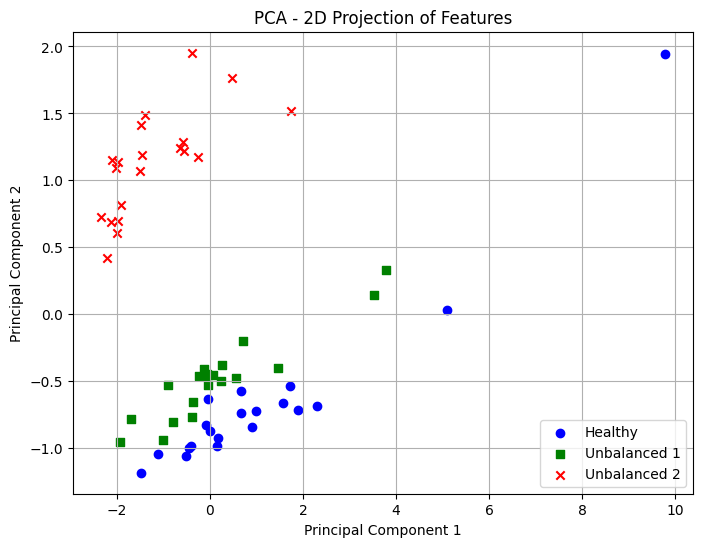

Explained Variance Ratio by PCA: [0.77996927 0.17314731]
Principal Component 1 loadings:
 [-0.23043855  0.49957679  0.499581    0.49989786  0.44479441]
Principal Component 2 loadings:
 [0.95148612 0.04221804 0.04214444 0.10129176 0.28435123]


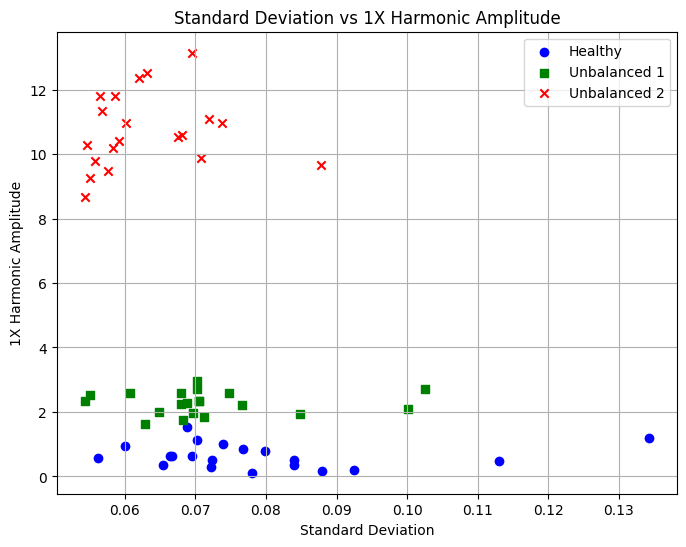

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prepare the combined feature matrix for PCA (all features: harmonic, std, rms, variance, ptp)
X_train_healthy = np.column_stack((healthy_harmonic, healthy_std, healthy_rms, healthy_var, healthy_ptp))
X_train_unbalanced1 = np.column_stack((unbalanced1_harmonic, unbalanced1_std, unbalanced1_rms, unbalanced1_var, unbalanced1_ptp))
X_train_unbalanced2 = np.column_stack((unbalanced2_harmonic, unbalanced2_std, unbalanced2_rms, unbalanced2_var, unbalanced2_ptp))

# Combine all training data into one feature matrix
X_train = np.vstack((X_train_healthy, X_train_unbalanced1, X_train_unbalanced2))

# Create corresponding labels for training data (0 = healthy, 1 = unbalanced 1, 2 = unbalanced 2)
y_train = np.concatenate((
    np.zeros(len(healthy_harmonic)),       # Label 0 for healthy
    np.ones(len(unbalanced1_harmonic)),    # Label 1 for unbalanced 1
    np.full(len(unbalanced2_harmonic), 2)  # Label 2 for unbalanced 2
))

# Standardize the features (PCA requires data to be standardized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA and reduce to 2 components for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[y_train == 0, 0], X_train_pca[y_train == 0, 1], color='blue', label='Healthy', marker='o')
plt.scatter(X_train_pca[y_train == 1, 0], X_train_pca[y_train == 1, 1], color='green', label='Unbalanced 1', marker='s')
plt.scatter(X_train_pca[y_train == 2, 0], X_train_pca[y_train == 2, 1], color='red', label='Unbalanced 2', marker='x')

# Add titles and labels
plt.title('PCA - 2D Projection of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Print explained variance ratio to understand how much variance is captured by the two components
print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

# Print the loadings (weights) for each feature in the first two principal components
pca_components = pca.components_
print(f"Principal Component 1 loadings:\n {pca_components[0]}")
print(f"Principal Component 2 loadings:\n {pca_components[1]}")

plt.figure(figsize=(8, 6))
plt.scatter(healthy_std, healthy_harmonic, color='blue', label='Healthy', marker='o')
plt.scatter(unbalanced1_std, unbalanced1_harmonic, color='green', label='Unbalanced 1', marker='s')
plt.scatter(unbalanced2_std, unbalanced2_harmonic, color='red', label='Unbalanced 2', marker='x')

plt.title('Standard Deviation vs 1X Harmonic Amplitude')
plt.xlabel('Standard Deviation')
plt.ylabel('1X Harmonic Amplitude')
plt.legend()
plt.grid(True)
plt.show()


Training Accuracy: 98.33%
Confusion Matrix (Training Set):
[[19  1  0]
 [ 0 20  0]
 [ 0  0 20]]


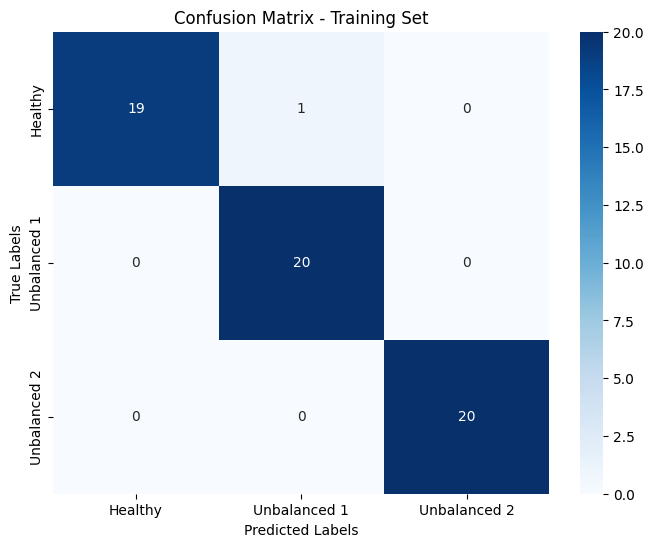


All files loaded in order:
1: Data Mar-26-14 Time 1533-21.txt
2: Data Mar-26-14 Time 1534-22.txt
3: Data Mar-26-14 Time 1540-23.txt
4: Data Mar-26-14 Time 1540-24.txt
5: Data Mar-26-14 Time 1540-25.txt
6: Data Mar-26-14 Time 1543-26.txt
7: Data Mar-26-14 Time 1543-27.txt
8: Data Mar-26-14 Time 1543-28.txt
9: Data Mar-26-14 Time 1544-29.txt
10: Data Mar-26-14 Time 1544-30.txt
11: Mar-26-14 Time 1549-12.txt
12: Mar-26-14 Time 1550-13.txt
13: Mar-26-14 Time 1550-14.txt
14: Mar-26-14 Time 1550-15.txt
15: Mar-26-14 Time 1551-16.txt
16: Mar-26-14 Time 1551-17.txt
17: Mar-26-14 Time 1551-18.txt
18: Mar-26-14 Time 1552-19.txt
19: Mar-26-14 Time 1552-20.txt
20: Mar-26-14 Time 1552-21.txt
21: Mar-26-14 Time 1606-21.txt
22: Mar-26-14 Time 1606-22.txt
23: Mar-26-14 Time 1607-23.txt
24: Mar-26-14 Time 1607-24.txt
25: Mar-26-14 Time 1611-25.txt
26: Mar-26-14 Time 1616-26.txt
27: Mar-26-14 Time 1617-27.txt
28: Mar-26-14 Time 1617-28.txt
29: Mar-26-14 Time 1618-29.txt
30: Mar-26-14 Time 1618-30.txt
T

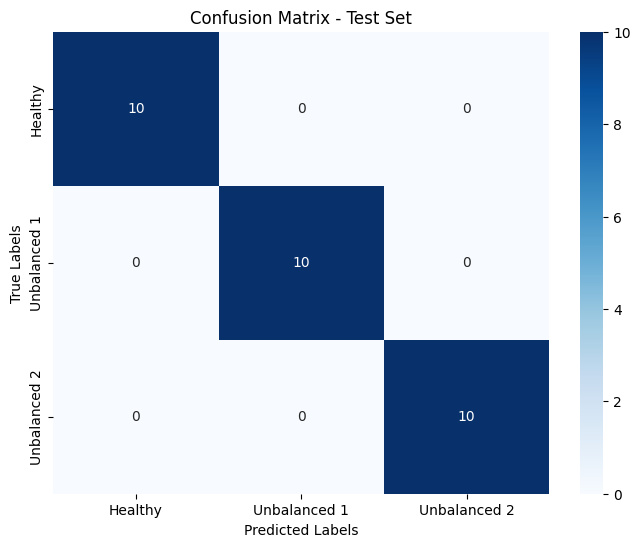

In [ ]:
# Combine training data into one feature matrix for SVM training (without RMS)
X_train_healthy = np.column_stack((healthy_harmonic, healthy_std))
X_train_unbalanced1 = np.column_stack((unbalanced1_harmonic, unbalanced1_std))
X_train_unbalanced2 = np.column_stack((unbalanced2_harmonic, unbalanced2_std))

# Combine the training feature matrix
X_train = np.vstack((X_train_healthy, X_train_unbalanced1, X_train_unbalanced2))

# Create corresponding labels for training data (0 = healthy, 1 = unbalanced 1, 2 = unbalanced 2)
y_train = np.concatenate((
    np.zeros(len(healthy_harmonic)),       # Label 0 for healthy
    np.ones(len(unbalanced1_harmonic)),    # Label 1 for unbalanced 1
    np.full(len(unbalanced2_harmonic), 2)  # Label 2 for unbalanced 2
))

# Standardize the feature values (important for SVM)
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training set
X_train_scaled = scaler.fit_transform(X_train)

# Train the SVM model on the entire training data
svm_model = SVC(kernel='linear')  # You can try 'rbf' or 'poly' kernels as well
svm_model.fit(X_train_scaled, y_train)

# Predict the labels for the training set
y_train_pred = svm_model.predict(X_train_scaled)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

print(f"Training Accuracy: {accuracy_train * 100:.2f}%")
print(f"Confusion Matrix (Training Set):\n{conf_matrix_train}")

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unbalanced 1', 'Unbalanced 2'], yticklabels=['Healthy', 'Unbalanced 1', 'Unbalanced 2'])
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Now process the test data
test_harmonic, test_std, _, _, _ = compute_features(test_data) # Use _ to discard unwanted returned values
X_test = np.column_stack((test_harmonic, test_std))
# Assuming test labels are known
y_test = np.concatenate((
    np.zeros(10),  # First 10 samples are healthy
    np.ones(10),   # Next 10 samples are unbalanced 1
    np.full(10, 2) # Last 10 samples are unbalanced 2
))

# Verify the order of the test files
test_files = sorted(os.listdir(test_path))

# Function to load vibration data
def load_vibration_data(file_path):
    return pd.read_csv(file_path, skiprows=5, header=None).to_numpy().flatten()

# Load test data in order and assign labels
test_data = []
test_labels = []

for i, file in enumerate(test_files):
    file_path = os.path.join(test_path, file)
    data = load_vibration_data(file_path)
    test_data.append(data)

    # Assign labels based on file position
    if i < 10:  # First 10 files are healthy
        test_labels.append(0)
    elif i < 20:  # Middle 10 files are unbalanced 1
        test_labels.append(1)
    else:  # Last 10 files are unbalanced 2
        test_labels.append(2)

# After loading, you can print the complete list of files loaded
print("\nAll files loaded in order:")
for i, file in enumerate(test_files):
    print(f"{i+1}: {file}")

# Convert to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Test data shape:", test_data.shape)
print("Test labels:", test_labels)

# Verify the labels
print("Assigned test labels:", test_labels)

# Compute features for the test data
test_harmonic, test_std, _, _, _ = compute_features(test_data) # Use _ to discard unwanted returned values

# Combine test features into feature matrix X_test
X_test = np.column_stack((test_harmonic, test_std))

# Standardize the test features using the previously fitted scaler
X_test_scaled = scaler.transform(X_test)

# Predict using the trained SVM model
y_pred = svm_model.predict(X_test_scaled)

# Print predicted and actual labels
print("Predicted Labels:", y_pred)
print("Actual Labels:", test_labels)

# Evaluate the model on the test set
accuracy = accuracy_score(test_labels, y_pred)
conf_matrix = confusion_matrix(test_labels, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unbalanced 1', 'Unbalanced 2'], yticklabels=['Healthy', 'Unbalanced 1', 'Unbalanced 2'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


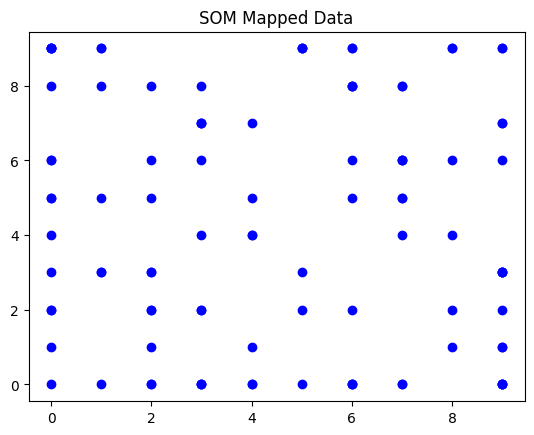

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

class SelfOrganizingMap:
    def __init__(self, x, y, input_len, learning_rate=0.5, sigma=None, max_iter=1000):
        self.x = x  # Width of the SOM grid
        self.y = y  # Height of the SOM grid
        self.input_len = input_len  # Length of the input vector
        self.learning_rate = learning_rate  # Initial learning rate
        self.sigma = sigma if sigma is not None else max(x, y) / 2  # Initial neighborhood radius
        self.max_iter = max_iter  # Number of iterations

        # Randomly initialize the weight vectors for each neuron in the grid
        self.weights = np.random.random((x * y, input_len))

        # Create a grid of neuron positions
        self.grid = np.array([[i, j] for i in range(x) for j in range(y)])

        # Decay functions for learning rate and sigma
        self.time_constant = max_iter / np.log(self.sigma)

    def find_bmu(self, input_vector):
        """Find the Best Matching Unit (BMU) for a given input vector."""
        distances = np.linalg.norm(self.weights - input_vector, axis=1)
        bmu_index = np.argmin(distances)
        return bmu_index

    def update_weights(self, input_vector, bmu_index, iteration):
        """Update the weights of the neurons, including neighbors of the BMU."""
        bmu_position = self.grid[bmu_index]
        learning_rate = self.learning_rate * np.exp(-iteration / self.max_iter)
        sigma = self.sigma * np.exp(-iteration / self.time_constant)

        # Compute the distances of each neuron to the BMU
        distances_to_bmu = np.linalg.norm(self.grid - bmu_position, axis=1)

        # Calculate the neighborhood function (Gaussian)
        neighborhood = np.exp(-(distances_to_bmu ** 2) / (2 * (sigma ** 2)))

        # Update the weights of all neurons
        for i, distance in enumerate(distances_to_bmu):
            influence = neighborhood[i]
            self.weights[i] += influence * learning_rate * (input_vector - self.weights[i])

    def train(self, data):
        """Train the SOM using the input data."""
        for iteration in range(self.max_iter):
            # Pick a random input vector from the data
            input_vector = data[np.random.randint(0, len(data))]

            # Find the BMU
            bmu_index = self.find_bmu(input_vector)

            # Update the weights of the BMU and its neighbors
            self.update_weights(input_vector, bmu_index, iteration)

    def map_input(self, input_vector):
        """Map an input vector to its BMU."""
        bmu_index = self.find_bmu(input_vector)
        return self.grid[bmu_index]

# Sample data
data = np.random.random((100, 4))  # Generate random 4D data (replace with your data)

# Normalize the data to [0, 1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Initialize and train the SOM
som = SelfOrganizingMap(x=10, y=10, input_len=4, learning_rate=0.5, max_iter=500)
som.train(data_scaled)

# Map the data to the SOM grid
mapped_data = np.array([som.map_input(x) for x in data_scaled])

# Plot the 2D SOM grid with the mapped data points
plt.scatter(mapped_data[:, 0], mapped_data[:, 1], c='blue', marker='o')
plt.title('SOM Mapped Data')
plt.show()
